# On Mining Multi-Time-Interval Sequential Patterns

#####Data mining is the process by which previously unknown, potentially usable data is extracted from databases. It has been established that sequential patterns occur frequently in large databases and several papers have been published about mining such sequential patterns. 

These algorithms for mining sequential patterns cannot establish the timeframe between two sequential events. Therefore, the focus shifted toward mining time-interval sequential patterns. Two approaches were proposed each having their own drawbacks. 
1. Setting fixed time intervals to measure time between each event, which has the drawback of having no exact measure of the time elapsed.
2. Measuring the exact time interval between successive events, with the drawback of having no way to measure the time between non-successive events.

##### Improving upon these became necessary. To that end, Ya-Han Hu et. al. in their paper, "On mining multi-time-interval sequential patterns", they describe two algorithms, the MI-Apriori Algorithm and the MI-PrefixSpan Algorithm for mining multi-time-interval sequential patterns. In this project, we strive to provide implementations for both these algorithms.

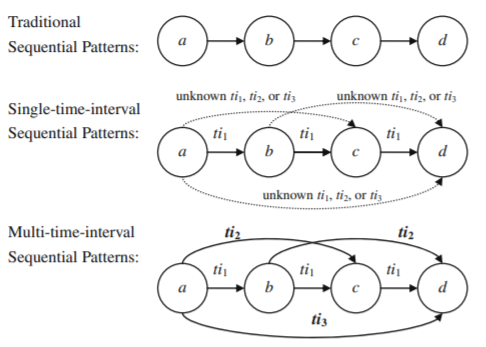

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
import sys
import re
from copy import deepcopy as copy
from collections import defaultdict
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import gc
%matplotlib inline

In [2]:
TIME_INTERVALS = [(0, 5), (5, float('inf'))]
# TIME_INTERVALS = [(0, 0), (0, 3), (3, 6), (6, float('inf'))]
MIN_SUP = 0.75
DB = [
	 [('a', 1), ('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)],
	 [('d', 5), ('a', 7), ('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)],
	 [('a', 8), ('b', 8), ('e', 11), ('d', 12), ('b', 13), ('c', 13), ('c', 16)],
	 [('b', 15), ('f', 15), ('e', 16), ('b', 17), ('c', 17)]
   ]
for row in DB:
	print(row)

[('a', 1), ('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)]
[('d', 5), ('a', 7), ('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)]
[('a', 8), ('b', 8), ('e', 11), ('d', 12), ('b', 13), ('c', 13), ('c', 16)]
[('b', 15), ('f', 15), ('e', 16), ('b', 17), ('c', 17)]


### **Properties of Multi Time Interval Sequence Patterns**

1. ***Descending Property:*** Each successive time interval in each &i of a multi-time interval sequence, is at most equal to the previous time interval. 
For example, (ti3, ti2, ti2,ti1) is valid, whereas, (ti2, ti3, ti2, ti1) is not valid.
2. ***Containing Property:*** A multi-time interval sequence is said to be contained in a data sequence if for every pair of items, the difference in the timestamps is same as that indicated in the multi-time interval sequence pattern. 
For example, {a,(ti1),b,(ti2,ti1),c,(ti2,ti1,ti1),d} is contained in data sequence A = {(a,1),(b,3),(c,5),(d,6),(e,8)} where ti0: 0; ti1: [0,3]; ti2: [3,6]; ti3: [6,∞).
3. ***Anti-Monotonicity Property:*** If a multi-time-interval sequence is frequent, so are all of its subsequences. Accordingly, if a multi-time-interval sequence is not frequent, then its super sequence will not be either. A sequence is said to be frequent if it has more than the minimum support specified for the data.
<br>Support of a multi-time interval sequence pattern is defined as the ratio of number of item sequences in which it is contained to the total number of item sequences in our database. 

In [3]:
# A class for multi time interval sequential patterns.
# Each pattern would contain a list of items in the sequence, 
# the list of intervals between them and the total number of items.
class multiTimeIntervalSequence:
  """A multi time interval sequence"""
  def __init__(self, items, intervals):
    self.items = items
    self.intervals = intervals
    self.length = len(items)

  def display(self):
    # assert self.items == sorted(self.items), "Assertion Error"
    print("Items: {0}, Intervals: {1}".format(self.items, self.intervals))

  def __hash__(self):
    return hash((tuple(self.items), tuple(tuple(i) for i in self.intervals)))
  
  def __eq__(self, other):
    """Equality operator overloading for Sequence class"""
    return self.length == other.length and self.items == other.items and self.intervals == other.intervals

<h1><b>Apriori Algorithm

In [4]:
# This function returns the interval to which the timestamp belongs.
# For example, for ('a', 3) and ('b', 8), the timestamp calculated would be 8-3 = 5.
# This function would go through the TIME_INTERVALS and get the time interval to which the timestamp 5 would belong.
# In this case, it would be (3, 6).
def get_interval(timestamp, time_intervals=TIME_INTERVALS):
	"""Returns interval corresponding to given timestamp"""
	timestamp = abs(timestamp)

	for interval in time_intervals:
		if timestamp >= interval[0] and timestamp <= interval[1]:
			return interval

# this function takes in the interval and returns the index of that interval in TIME_INTERVALS
def get_interval_index(interval, time_intervals=TIME_INTERVALS):
  """"Returns the index of the interval according to the
	list of intervals"""
  return time_intervals.index(interval)
 
# Testing
print(get_interval(5))
print(get_interval_index(get_interval(5)))

(0, 5)
0


In [5]:
# To get the time interval information matrix as described in the paper.
def generate_time_interval_information_matrix(ti, show=False):
  """Creating the Time Interval Information Matrix"""
  table = [[[] for i in range(len(ti))] for j in range(len(ti))]
  table[0][0].append(ti[0])

  for i in range(1, len(ti)-1):
    for j in range(i+1):
      left = ti[i][0] + ti[j][0]
      right = ti[i][1] + ti[j][1]

      for t in ti[1:]:
        if left <= t[0] <= t[1] <= right or (left <= t[0] <= t[1] and ti[-1][0]<right<=float('inf')):
          table[i][j].append(t)
  for i in range(len(ti)):
    table[-1][i].append(ti[-1])
  if show:
    for each in table:
      print(each)

  return table

# testing
table = generate_time_interval_information_matrix(ti=TIME_INTERVALS, show=True)


[[(0, 5)], []]
[[(5, inf)], [(5, inf)]]


In [6]:
# This function takes in a sequence of items and its timestamps and a multi-time-interval-pattern
# and finds out whether the pattern is contained in the sequence.
def contains(transaction, sequence, timeIntervals=TIME_INTERVALS):
  """Returns True if MTI-sequence is contained in transaction/item sequence as per multi-time
  interval sequence's "contains" definition.
  Arguments:
      transaction: A transaction from a sequence database containing
      (item, timestamp) tuples sorted according to timestamp
      sequence: A multi time interval sequence
  """
  unknown_items = copy(sequence.items)
  known_tuples = []

  def recursive_contains(known_tuples, unknown_items, transaction, sequence):
    """recursive_contains

    Arguments:
        known_tuples:
        unknown_items:
        transaction:
        sequence:
    """
    if len(unknown_items) == 0:
      return True
    
    # Finding all the tuples with item equal to the first of the unknown_items list along with its indices.
    # After this, the first of the unknown_items list is discarded for the next recursive call.
    item_tuples_in_transaction = [(item_tuple, index) for index, item_tuple in enumerate(transaction) if item_tuple[0] == unknown_items[0]]

    # index is also required because the items before the current item can no longer play a role in matching with the pattern
    # therefore, only the items with a timestamp greater than the current one is passed to the next recursive call.
  
    for item_tuple, index in item_tuples_in_transaction:
      if not passes_validity(item_tuple, known_tuples, sequence, timeIntervals):
        continue

      cur_known = known_tuples + [item_tuple]
      if recursive_contains(cur_known, unknown_items[1:], transaction[index+1:], sequence):
        return True

    return False
    # end function recursive_contains
  return recursive_contains(known_tuples, unknown_items, transaction, sequence)

# second condition
def passes_validity(item_tuple, known_tuples, sequence, timeIntervals=TIME_INTERVALS):
  """Returns True if item_tuple(item, timestamp) passes the time interval
  validity , i.e the time difference between item and each item in
  known_tuples should belong to the same interval as specified in
  sequence.intervals
  Arguments:
      item_tuple:
      known_tuples:
      sequence:
  """

  # This function checks the second condition for the "contains" definition.
  # It checks the time_interval for each of the previous known tuples and 
  # cross checks it with the intervals specified in the Multi-time-interval-sequence passed to it.

  cur_item, cur_timestamp = item_tuple
  cur_idx = len(known_tuples)
  
  for idx, (item, timestamp) in enumerate(known_tuples):

    cur_interval = get_interval(cur_timestamp - timestamp, time_intervals=timeIntervals)
    if cur_interval != sequence.intervals[cur_idx - 1][idx]:
      return False

  return True

# Testing
# Case 1
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'd'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(3, 6), (0, 3), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

# Case 2
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'e'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(3, 6), (0, 3), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

# Case 3
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'e'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(6, float('inf')), (3, 6), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

False
False
False


In [7]:
def support(sequence, db, timeIntervals=TIME_INTERVALS, verbose=False):
  """Returns support of multiTimeIntervalSequence sequence in db
  This is equal to number of rows containing sequence
  divided by total number of rows"""
  item_in_rows = 0.0
  num_rows = len(db)
  transactions = []

  for row in db:
    if contains(row, sequence, timeIntervals=timeIntervals):
      item_in_rows += 1
      transactions.append(row)

  if verbose:
    print("The given sequence is present in the following transactions")
    for idx, row in enumerate(transactions):
      print("{0} : {1}".format(idx, row))

  return item_in_rows/num_rows


items=['a', 'b', 'e']
ti1=(0,5)
ti2=(5,float('inf'))
intervals= [[ti1],[ti2,ti2]]
sequence_ = multiTimeIntervalSequence(items=items, intervals=intervals)
support(sequence_, db=DB)*4
# testing
sequence_ = multiTimeIntervalSequence(items=['c', 'f', 'b'], intervals=[[(3, 6)], [(6, float('inf')), (0, 3)]])
support(sequence_, db=DB)

0.0

In [8]:
# To generate distinct elements that satisfy the minimum support requirement.
def generate_one_item_sets(db, min_support):
  """Generates one item sets from a database of data sequences 
  containing data in the form of (item, timestamp) tuples."""
  unique_item_count = {}
  for row in db:
    count = {}
    for item, timestamp in row:
      try:
        count[item] += 1
      except:
        count[item] = 1
    for key in count:
      try:
        unique_item_count[key] += 1
      except:
        unique_item_count[key] = 1

  return list(filter(lambda x: unique_item_count[x]/len(db) >= min_support, unique_item_count.keys()))

# Testing
one_item_sets = generate_one_item_sets(db=DB, min_support=0.5)
one_item_sets

['a', 'b', 'c', 'e', 'd']

In [9]:
def joinC2(one_itemsets, time_intervals, min_support,db=DB):
  """ Joins 1-multi-time-interval sequences with itself and returns a
  2-multi-time-interval sequence
  Arguments:
      one_itemsets: frequent one itemsets from the DB
      time_intervals: time intervals defined
  """
  list_of_sequences = []
  sequence_hashMap = defaultdict(lambda: False)
  for item_1 in one_itemsets:
    for item_2 in one_itemsets:
      t_items = [item_1, item_2]
      for interval in time_intervals:
        t_intervals = [[interval]]
        mtiseq = multiTimeIntervalSequence(t_items, t_intervals)
        if not sequence_hashMap[mtiseq]:
          sequence_hashMap[mtiseq] = True
          if support(sequence=mtiseq, db=db, timeIntervals=time_intervals) >= min_support:
            list_of_sequences.append(mtiseq)
  return list_of_sequences
# Testing
two_item_sets = joinC2(one_itemsets=one_item_sets, time_intervals=TIME_INTERVALS, min_support=MIN_SUP)
for sequence in two_item_sets:
  sequence.display()
print(len(two_item_sets))

Items: ['a', 'b'], Intervals: [[(0, 5)]]
Items: ['a', 'c'], Intervals: [[(5, inf)]]
Items: ['a', 'e'], Intervals: [[(0, 5)]]
Items: ['b', 'c'], Intervals: [[(0, 5)]]
Items: ['b', 'c'], Intervals: [[(5, inf)]]
Items: ['b', 'e'], Intervals: [[(0, 5)]]
Items: ['e', 'c'], Intervals: [[(0, 5)]]
7


In [10]:
def joinable(k1, k2):
  """Returns True if the two k-multi-time-interval sequence are joinable into
  a k+1-multi-time-interval sequence
  Arguments:
      k1: k-multi-time-interval
      k2: k-multi-time-interval
  """
  if k1.length != k2.length:
    return False
  if k1.items[1:] != k2.items[:-1]:
    return False
  if k1.length == 2: # There wont be any time intervals here to check
    return True
  intervals_1 = []
  for intervals in k1.intervals[1:]:
    intervals_1.append(intervals[1:])
  intervals_2 = k2.intervals[:-1]
  if intervals_1 != intervals_2:
    return False
  return True

In [11]:
def joinCk(k1, k2, timeIntervalMatrix, min_support, sequence_hashMap, db, time_intervals=TIME_INTERVALS):
  """ Joins two k-multi-time-interval sequences and returns a
  k+1-multi-time-interval sequence
  Arguments:
      k1: k-multi-time-interval
      k2: Another k-multi-time-interval
      timeIntervalMatrix: Time interval matrix constructed using
      time intervals defined
  """
  list_of_sequences = []
  items = copy(k1.items)
  items.append(k2.items[-1])
  intervals = copy(k1.intervals)
  intervals.append(copy(k2.intervals[-1]))
  T_1_kminus1 = k1.intervals[-1][0]
  T_kminus1_k = k2.intervals[-1][-1]
  i = get_interval_index(T_1_kminus1, time_intervals=time_intervals)
  j = get_interval_index(T_kminus1_k, time_intervals=time_intervals)
  if i < j: # Time interval matrix we construct is upper triangular
    i, j = j, i
  # Descending Property + Time Interval Matrix Property
  for interval in timeIntervalMatrix[i][j]:
    # T_1_k should be >= T_2_k
    if get_interval_index(interval, time_intervals=time_intervals) >= get_interval_index(intervals[-1][0], time_intervals=time_intervals):
      t_intervals = copy(intervals)
      t_intervals[-1].insert(0, interval)
      mtiseq = multiTimeIntervalSequence(items, t_intervals)
      if not sequence_hashMap[mtiseq]:
        sequence_hashMap[mtiseq] = True
        if support(sequence=mtiseq, db=db, timeIntervals=time_intervals) >= min_support:
          list_of_sequences.append(mtiseq)
  return list_of_sequences

In [12]:
#@title Apriori Algorithm - Class Implementation { form-width: "20%" }
class MultiTimeIntervalApriori:
    """Implements the Multi Time Interval Apriori Algorithm
    multi-time-interval-sequences will be referred to as MTIS in comments"""

    def __init__(self, db=DB, timeIntervals=TIME_INTERVALS, min_support=MIN_SUP):
      self.__db = db
      self.__timeIntervals = timeIntervals
      self.__timeIntervalMatrix = generate_time_interval_information_matrix(ti=self.__timeIntervals)
      self.__min_sup = min_support
      self.__oneItemsets = generate_one_item_sets(db=self.__db, min_support=self.__min_sup)
      self.__frequentSequences = defaultdict(list)
      self.__time_taken = 0
    
    def getFrequentSequences(self, k=None):
      if k is None:
        return self.__frequentSequences
      return self.__frequentSequences[k]
    
    def find_time_taken(self):
      return self.__time_taken

    def display_count_of_sequences(self, k=None):
      if not k:
        for each in self.__frequentSequences:
          print("{0}-MTIS Sequences Generated: {1}".format(each, len(self.__frequentSequences[each])))
      else:
        print("{0}-MTIS Sequences Generated: {1}".format(k, len(self.__frequentSequences[k])))
    
    def run_multi_time_interval_apriori(self, max_sequence_length=10, verbose=False, measure_time=False):
      """
      Stub function to run the apriori algorithm.
      Arguments:
        max_sequence_length: Maximum multiTimeIntervalSequence length
      """
      for each in self.__oneItemsets:
        self.__frequentSequences[1].append(multiTimeIntervalSequence([each], []))
      self.__time_taken = time.time()
      self.__frequentSequences[2] = joinC2(one_itemsets=self.__oneItemsets, time_intervals=self.__timeIntervals, min_support=self.__min_sup, db=self.__db)
    
      for k in range(3, max_sequence_length + 1):
        # 'Generating {k} - Multi Time Interval Sequences'
        # Get all C_{k-1} MTIS
        kminus1_sequences = self.__frequentSequences[k-1]
        current_ksequence_list = []

        sequence_hashMap = defaultdict(lambda:False)
        for sequence_1 in kminus1_sequences:
          for sequence_2 in kminus1_sequences:
            if joinable(sequence_1, sequence_2):
              # This can generate multiple Ck sequences
              new_k_sequences = joinCk(sequence_1, sequence_2, self.__timeIntervalMatrix, self.__min_sup, sequence_hashMap=sequence_hashMap, db=self.__db, time_intervals=self.__timeIntervals)
              current_ksequence_list += new_k_sequences
        if len(current_ksequence_list) == 0:
          break
        self.__frequentSequences[k] = current_ksequence_list

      if verbose:
        for each in self.__frequentSequences:
          print("{0}-MTIS Sequences Generated".format(each))
          for sequence in self.__frequentSequences[each]:
            sequence.display()

      self.__time_taken = time.time() - self.__time_taken
      if measure_time:
        print("Time Taken: {0}".format(self.__time_taken))

In [13]:
apriori_model = MultiTimeIntervalApriori(db=DB, min_support=0.75, timeIntervals=TIME_INTERVALS)

In [14]:
apriori_model.run_multi_time_interval_apriori(verbose=True, measure_time=False)

1-MTIS Sequences Generated
Items: ['a'], Intervals: []
Items: ['b'], Intervals: []
Items: ['c'], Intervals: []
Items: ['e'], Intervals: []
2-MTIS Sequences Generated
Items: ['a', 'b'], Intervals: [[(0, 5)]]
Items: ['a', 'c'], Intervals: [[(5, inf)]]
Items: ['a', 'e'], Intervals: [[(0, 5)]]
Items: ['b', 'c'], Intervals: [[(0, 5)]]
Items: ['b', 'c'], Intervals: [[(5, inf)]]
Items: ['b', 'e'], Intervals: [[(0, 5)]]
Items: ['e', 'c'], Intervals: [[(0, 5)]]
3-MTIS Sequences Generated
Items: ['a', 'b', 'c'], Intervals: [[(0, 5)], [(5, inf), (5, inf)]]
Items: ['a', 'b', 'e'], Intervals: [[(0, 5)], [(0, 5), (0, 5)]]


In [15]:
apriori_model.display_count_of_sequences()

1-MTIS Sequences Generated: 4
2-MTIS Sequences Generated: 7
3-MTIS Sequences Generated: 2


In [16]:
apriori_model.find_time_taken()

0.01936173439025879

In [17]:
apriori_model.getFrequentSequences()

defaultdict(list,
            {1: [<__main__.multiTimeIntervalSequence at 0x7ff5fb7b4610>,
             2: [<__main__.multiTimeIntervalSequence at 0x7ff5fb7b4110>,
             3: [<__main__.multiTimeIntervalSequence at 0x7ff5fb79be10>,
              <__main__.multiTimeIntervalSequence at 0x7ff5fb7a2410>]})

<h1><b>PrefixSpan Algorithm

In [18]:
def generate_intervals(item_sequence, time_intervals=TIME_INTERVALS):
  """
  Goal: Generate intervals based on item sequence given
  Input:
    item_sequence: The sequence of timestamped items whose time_intervals are required.
    time_intervals: The time_interval_database used for generating the intervals
  Output:
    intervals: The list of time differences in MTIS format
  """
  intervals = []
  if len(item_sequence) <= 1:
    return intervals
  for i in range(1,len(item_sequence)):
    interval = []
    for j in range(i):
      interval.append(get_interval(item_sequence[i][1] - item_sequence[j][1], time_intervals=time_intervals))
    intervals.append(interval)
  return intervals

# Testing
generate_intervals([('d', 12), ('b', 13), ('c',13), ('c', 16)]) 

[[(0, 5)], [(0, 5), (0, 5)], [(0, 5), (0, 5), (0, 5)]]

In [19]:
class ProjectionNotation:
  
  def __init__(self, index, items, timestamps):
    self.index = index
    self.items = items
    self.timestamps = timestamps
    assert len(self.timestamps) == len(self.items)
  
  def display_projection_notation(self,verbose=True,end='\n'):
    if verbose:
      print("Projection Notation: {0}".format([self.index, self.items, self.timestamps]), end=end)
    else:
      return [self.index, self.items, self.timestamps]

  def display_projection(self, db, verbose=True):
    data = db[self.index]
    start = self.items[-1]
    self.projection = data[start:]
    if verbose:
      print("Projection: {0}".format(self.projection))
    else:
      return self.projection

  def display_prefix(self, db, verbose=True):
    item_sequence = [db[self.index][i-1] for i in self.items]
    items = [item[0] for item in item_sequence]
    intervals = generate_intervals(item_sequence=item_sequence)
    self.prefix = multiTimeIntervalSequence(items=items, intervals=intervals)
    if verbose:
      self.prefix.display()
    else:
      return self.prefix

# Testing
notation1 = ProjectionNotation(0, [1], [1])
notation1.display_projection(db=DB)
notation1.display_prefix(db=DB)

notation2 = ProjectionNotation(1, [2], [7])
notation2.display_projection(db=DB)
notation2.display_prefix(db=DB)

notation3 = ProjectionNotation(2, [1,3], [8,11])
notation3.display_projection(db=DB)
notation3.display_prefix(db=DB)


Projection: [('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)]
Items: ['a'], Intervals: []
Projection: [('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)]
Items: ['a'], Intervals: []
Projection: [('d', 12), ('b', 13), ('c', 13), ('c', 16)]
Items: ['a', 'e'], Intervals: [[(0, 5)]]


In [20]:
generate_one_item_sets(db=DB, min_support=0.5)

['a', 'b', 'c', 'e', 'd']

In [21]:
def check_descending(list_of_time_intervals, ti=TIME_INTERVALS):
  indices = []
  for interval in list_of_time_intervals:
    indices.append(get_interval_index(interval, time_intervals=ti))
  return indices == sorted(indices)[::-1]

# Testing
# print(check_descending([(0, 0), (0, 3)]))
# print(check_descending([(3, 6), (0, 3)]))
# print(check_descending([(0, 3), (0, 3), (0, 0)]))
# print(check_descending([(0, 3), (0, 3)]))

In [22]:
def is_ascending(list_of_items):
  return list_of_items==sorted(list_of_items)

In [23]:
def uniqueSupportCount(list_of_items):
  countUnique = defaultdict(bool)
  for sequenceItem in list_of_items:
    countUnique[sequenceItem[0]] = True
  x = len(countUnique.keys())
  del countUnique
  gc.collect()
  return x

In [24]:
def check_validity(intervals):
  for i in range(len(intervals)-1):
    one_dif = []
    for j in range(i, len(intervals)):
      one_dif.append(intervals[j][i])
    if not is_ascending(one_dif):
      return False
  return True

In [25]:
a = {'a':'12312321', 'b':'sadfs'}
print({a:len(b) for a,b in a.items()})

{'a': 8, 'b': 5}


In [26]:
class MultiTimeIntervalPrefixSpan:
  """Implements the Multi Time Interval PrefixSpan Algorithm"""

  def __init__(self, db=DB, timeIntervals=TIME_INTERVALS, min_support=MIN_SUP):
    self.__db = db
    self.__time_intervals = timeIntervals
    self.__min_sup = min_support
    self.__frequent_one_item_sets = generate_one_item_sets(db=self.__db, min_support=self.__min_sup)
    self.__frequentSequences = defaultdict(list)
    self.__projections = defaultdict(list)
    self.__time_taken = 0
  
  def getIntervals(self, timestamps, data):
    """
    Goal: to output the set of intervals so that MTIS can be expanded.
    Input:
      timestamps: the timestamps of items in the prefix
      data: the item sequence of the current projection being evaluated
    Output:
      sols: a list of the intervals in which each time difference would lie in for each item in 'data'
    """
    sols = []
    for item, timestamp in data:
        intervals = []
        for i in timestamps:
            intervals.append(get_interval(timestamp=timestamp-i, time_intervals=self.__time_intervals))
        sols.append(intervals)
    return sols

  def generate_frequent_candidates(self, alpha):
    """
    Goal: to generate the frequent candidates for the generation of larger MTIS patterns
    Input:
      alpha: the current prefix/multi-time-interval sequence that is being considered for projection
    Output:
      candidates: a list of all candidate items and information about its intervals, position in database etc.
    """
    candidate_frequency_map = defaultdict(list)
    for projectionNotation in self.__projections[alpha]:      
        data = projectionNotation.display_projection(db=self.__db, verbose=False)
        intervals = self.getIntervals(timestamps=projectionNotation.timestamps , data=data)
        for j, [item, timestamp] in enumerate(data):
            candidate_frequency_map[(item, tuple(intervals[j]))].append((projectionNotation.index, projectionNotation.items[-1] + j))
        del data
        del intervals
        gc.collect()
    for entry in candidate_frequency_map:
        if uniqueSupportCount(candidate_frequency_map[entry]) >= self.__min_sup * len(self.__db) and check_descending(list(entry[1]), ti=self.__time_intervals):
            yield [entry, candidate_frequency_map[entry]]
    del candidate_frequency_map
    gc.collect()
  
  def find_one_projections(self, gamma):
    """
    Goal: To find the projected database of one item sequences
    Input: 
      gamma: a frequent item in the database
    Output:
      s_given_alpha_dash: the projected database for gamma
    """
    s_given_alpha_dash = []
    for j, row in enumerate(self.__db):
      for j_, [item, timestamp] in enumerate(row):
        if item == gamma:
          projection = ProjectionNotation(index=j, items=[j_+1], timestamps=[timestamp])
          if projection.display_projection(db=self.__db,verbose=False):
            s_given_alpha_dash.append(projection)
    return s_given_alpha_dash

  def miPrefixSpan(self, alpha, k, s_given_alpha, max_sequence_length, verbose=False):
    stack = []
    if k!=0 and not s_given_alpha:
        return None
    for item in self.__frequent_one_item_sets:
        stack.append(multiTimeIntervalSequence(items=[item], intervals=[]))
        self.__projections[stack[-1]] = self.find_one_projections(gamma=item)
    del self.__frequent_one_item_sets
    while stack:
        alpha = stack.pop(0)
        self.__frequentSequences[alpha.length].append(alpha)
        if alpha.length == max_sequence_length:
            continue
        for candidate in self.generate_frequent_candidates(alpha):
            newItem, newIntervals = candidate[0]
            if not check_validity(alpha.intervals+[list(newIntervals)]):
                continue
            stack.append(multiTimeIntervalSequence(items=alpha.items+[newItem], intervals=alpha.intervals+[list(newIntervals)]))
            for projection in self.__projections[alpha]:
                index, items, timestamps = projection.display_projection_notation(verbose=False)
                for dbIndex, rowIndex in candidate[1]:
                    if index==dbIndex and (rowIndex+1)!=len(self.__db[dbIndex]) and is_ascending(items+[rowIndex+1]):
                        self.__projections[stack[-1]].append(ProjectionNotation(index=dbIndex, items=items+[rowIndex+1], timestamps=timestamps+[self.__db[dbIndex][rowIndex][1]]))
                del index
                del items
                del timestamps
                gc.collect()
        del self.__projections[alpha]
        del alpha
        gc.collect()
            
  
  def miPrefixSpanRecursive(self, alpha, k, s_given_alpha, max_sequence_length, verbose=True):
    """
    Goal: recursive function to generate all possible MTIS patterns
    Input:
      alpha: the current MTIS that we are trying to expand
      k: length of the current MTIS patter
      s_given_alpha: the projected database for alpha
      max_sequence_length: the recursion depth limit
      verbose: output display control variable
    Output:
    """
    if k!=0 and not s_given_alpha:
      return None
    if k+1>max_sequence_length:
      return None
    alpha_dash = []
    if k==0:
      for item in self.__frequent_one_item_sets:
        current_alpha_dash = multiTimeIntervalSequence(items=[item], intervals=[])
        alpha_dash.append(current_alpha_dash)
        s_given_alpha_dash = self.find_one_projections(gamma=item)
        current_alpha_dash.display()
        self.__frequentSequences[k+1].append(current_alpha_dash)
        # recursively call the algorithm with the new alpha and its projected database
        self.miPrefixSpanRecursive(current_alpha_dash, k+1, s_given_alpha_dash, max_sequence_length)
        del s_given_alpha_dash
        gc.collect()
  
    else:
      # Generate frequent Candidates
      for candidate in self.generate_frequent_candidates(alpha):
        newItem, newIntervals = candidate[0]
        list_of_dbIndex_and_rowIndex = candidate[1]
        if not check_validity(alpha.intervals+[list(newIntervals)]):
          continue
        current_alpha = multiTimeIntervalSequence(items=alpha.items+[newItem], intervals=alpha.intervals+[list(newIntervals)])
        alpha_dash.append(current_alpha)
        current_alpha.display()
        self.__frequentSequences[k+1].append(current_alpha)
        # Generate New Projection Database, s_given_alpha_dash from s_given_alpha
        s_given_alpha_dash = []
        for projection in s_given_alpha:
          index, items, timestamps = projection.display_projection_notation(verbose=False)
          for dbIndex, rowIndex in list_of_dbIndex_and_rowIndex:
            if index == dbIndex and (rowIndex+1)!=len(self.__db[dbIndex]) and is_ascending(items+[rowIndex+1]):
              newProjection = ProjectionNotation(index=dbIndex, items=items+[rowIndex+1], timestamps=timestamps+[self.__db[dbIndex][rowIndex][1]])
              s_given_alpha_dash.append(newProjection)
        # Recursively call the algorithm with the new MTIS pattern and the new projected database computed
        self.miPrefixSpanRecursive(alpha=current_alpha, k=k+1, s_given_alpha=s_given_alpha_dash, max_sequence_length=max_sequence_length)
        del s_given_alpha_dash
    del alpha_dash
    gc.collect()

  def getFrequentSequences(self, k=None):
    if k is None:
        return self.__frequentSequences 
    return self.__frequentSequences[k]

  def display_count_of_sequences(self, k=None):
    """
    Goal: To display the count of the sequences generated. Will display nothing if algorithm has not yet been run.
    Input: 
      k: Optional Parameter for length of sequence
    """
    if not k:
      for each in self.__frequentSequences:
        print("{0}-MTIS Sequences Generated: {1}".format(each, len(self.__frequentSequences[each])))
    else:
      print("{0}-MTIS Sequences Generated: {1}".format(k, len(self.__frequentSequences[k])))

  def find_time_taken(self):
    """
    Goal: To return the time taken to run the algorithm. (will display 0 if alg has not yet been run)
    Output:
      __time_taken: the time_taken for the alg to run.
    """
    return self.__time_taken

  def runPrefixSpan(self, max_sequence_length=10, measure_time=False, verbose=False, recursion_enabled=True):
    self.__time_taken = time.time()
    self.__frequentSequences = defaultdict(list)
    if recursion_enabled:
        self.miPrefixSpanRecursive(alpha=multiTimeIntervalSequence(items=[], intervals=[]), k=0, s_given_alpha=[], max_sequence_length=max_sequence_length)
    else:
        self.miPrefixSpan(alpha=multiTimeIntervalSequence(items=[], intervals=[]), k=0, s_given_alpha=[], max_sequence_length=max_sequence_length)
    if verbose:
      for each in self.__frequentSequences:
        print("{0}-MTIS Sequences Generated".format(each))
        for sequence in self.__frequentSequences[each]:
          sequence.display()
    self.__time_taken = time.time()-self.__time_taken
    if measure_time:
      print(self.__time_taken)

In [27]:
prefixSpan = MultiTimeIntervalPrefixSpan(db=DB, timeIntervals=TIME_INTERVALS, min_support=0.75)

In [28]:
prefixSpan.runPrefixSpan(verbose=True, measure_time=True, recursion_enabled=False)

1-MTIS Sequences Generated
Items: ['a'], Intervals: []
Items: ['b'], Intervals: []
Items: ['c'], Intervals: []
Items: ['e'], Intervals: []
2-MTIS Sequences Generated
Items: ['a', 'b'], Intervals: [[(0, 5)]]
Items: ['a', 'e'], Intervals: [[(0, 5)]]
Items: ['a', 'c'], Intervals: [[(5, inf)]]
Items: ['b', 'c'], Intervals: [[(0, 5)]]
Items: ['b', 'e'], Intervals: [[(0, 5)]]
Items: ['b', 'c'], Intervals: [[(5, inf)]]
Items: ['e', 'c'], Intervals: [[(0, 5)]]
3-MTIS Sequences Generated
Items: ['a', 'b', 'e'], Intervals: [[(0, 5)], [(0, 5), (0, 5)]]
Items: ['a', 'b', 'c'], Intervals: [[(0, 5)], [(5, inf), (5, inf)]]
8.03691816329956


In [29]:
prefixSpan.display_count_of_sequences()

1-MTIS Sequences Generated: 4
2-MTIS Sequences Generated: 7
3-MTIS Sequences Generated: 2


In [30]:
prefixSpan.find_time_taken()

8.03691816329956

In [31]:
prefixSpan.getFrequentSequences()

defaultdict(list,
            {1: [<__main__.multiTimeIntervalSequence at 0x7ff5fb79f710>,
             2: [<__main__.multiTimeIntervalSequence at 0x7ff60085df50>,
             3: [<__main__.multiTimeIntervalSequence at 0x7ff602e5bb90>,
              <__main__.multiTimeIntervalSequence at 0x7ff5ffa34f90>]})

<h1><b>Dataset

In [ ]:
# importing the prepared jewelry dataset
data = pd.read_csv('./Jewelry_prepared.csv')

In [ ]:
data.shape

(100603, 2)

In [ ]:
data.sample(10)

,transaction_id,item
20141,28,"(30, '2')"
62102,50,"(10, '12')"
83259,66,"(13, '30')"
83846,67,"(10, '2')"
37963,5,"(10, '12')"
9898,19,"(23, '6')"
38786,5,"(23, '16')"
81257,65,"(23, '17')"
21876,29,"(12, '16')"
10823,19,"(12, '10')"


In [ ]:
# Converting the string items into useable integer format
data.item = data.item.apply(lambda stringRow: tuple(map(int, re.findall('\d+', stringRow))))

In [ ]:
data.head()

,transaction_id,item
0,0,"(23, 29)"
1,0,"(23, 29)"
2,0,"(10, 29)"
3,0,"(16, 29)"
4,0,"(5, 29)"


In [ ]:
# getting all the purchases as a list
transactions = data.groupby('transaction_id')['item'].apply(list).to_dict()

In [ ]:
# Sorting the items in each transaction according to timestamp and getting dataset in useable format
db = []
for transaction, items in transactions.items():
  db.append(sorted(items, key=lambda item: item[1]))

In [ ]:
time_intervals = [(0, 3),(3, 7),(7, 11)]

In [ ]:
generate_time_interval_information_matrix(ti=time_intervals)

[[[(0, 3)], [], []],
 [[(3, 7), (7, 11)], [(7, 11)], []],
 [[(7, 11)], [(7, 11)], [(7, 11)]]]

In [ ]:
apriori = MultiTimeIntervalApriori(db=db, min_support=0.9, timeIntervals=time_intervals)

In [ ]:
apriori.run_multi_time_interval_apriori(max_sequence_length=3, measure_time=True, verbose=True)

1-MTIS Sequences Generated
Items: [23], Intervals: []
Items: [10], Intervals: []
Items: [16], Intervals: []
Items: [5], Intervals: []
Items: [12], Intervals: []
Items: [18], Intervals: []
Items: [19], Intervals: []
Items: [13], Intervals: []
Items: [26], Intervals: []
Items: [32], Intervals: []
Items: [25], Intervals: []
Items: [27], Intervals: []
Items: [8], Intervals: []
Items: [7], Intervals: []
Items: [29], Intervals: []
2-MTIS Sequences Generated
Items: [23, 23], Intervals: [[(0, 3)]]
Items: [23, 23], Intervals: [[(3, 7)]]
Items: [23, 10], Intervals: [[(0, 3)]]
Items: [23, 10], Intervals: [[(3, 7)]]
Items: [23, 16], Intervals: [[(0, 3)]]
Items: [23, 16], Intervals: [[(3, 7)]]
Items: [23, 5], Intervals: [[(0, 3)]]
Items: [23, 5], Intervals: [[(3, 7)]]
Items: [23, 12], Intervals: [[(0, 3)]]
Items: [23, 12], Intervals: [[(3, 7)]]
Items: [23, 18], Intervals: [[(0, 3)]]
Items: [23, 18], Intervals: [[(3, 7)]]
Items: [23, 19], Intervals: [[(0, 3)]]
Items: [23, 19], Intervals: [[(3, 7)]]


Items: [12, 16, 5], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 5], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 12], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 12], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 18], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 18], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 19], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 19], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 13], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 13], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 26], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 32], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 32], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 25], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 25], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [12, 16, 27], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [12, 16, 27], Inter

Items: [27, 10, 5], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 12], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 12], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 18], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 18], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 19], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 19], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 13], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 13], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 32], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 25], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 27], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 27], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 8], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 7], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 10, 7], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [27, 10, 29], Interva

In [ ]:
apriori.display_count_of_sequences()

1-MTIS Sequences Generated: 15
2-MTIS Sequences Generated: 337
3-MTIS Sequences Generated: 5304


In [ ]:
aprioriFrequentSequences = apriori.getFrequentSequences()
type(aprioriFrequentSequences)

collections.defaultdict

In [ ]:
with open('Apriori - Frequent Sequences.json', 'w') as file:
    json.dump(aprioriFrequentSequences, file, default=vars)

In [ ]:
prefixspan = MultiTimeIntervalPrefixSpan(db=db, min_support=0.9, timeIntervals=time_intervals)

In [ ]:
prefixspan.runPrefixSpan(max_sequence_length=3, measure_time=True, verbose=True)

1-MTIS Sequences Generated
Items: [23], Intervals: []
Items: [10], Intervals: []
Items: [16], Intervals: []
Items: [5], Intervals: []
Items: [12], Intervals: []
Items: [18], Intervals: []
Items: [19], Intervals: []
Items: [13], Intervals: []
Items: [26], Intervals: []
Items: [32], Intervals: []
Items: [25], Intervals: []
Items: [27], Intervals: []
Items: [8], Intervals: []
Items: [7], Intervals: []
Items: [29], Intervals: []
2-MTIS Sequences Generated
Items: [23, 23], Intervals: [[(0, 3)]]
Items: [23, 23], Intervals: [[(3, 7)]]
Items: [23, 10], Intervals: [[(0, 3)]]
Items: [23, 10], Intervals: [[(3, 7)]]
Items: [23, 16], Intervals: [[(0, 3)]]
Items: [23, 16], Intervals: [[(3, 7)]]
Items: [23, 5], Intervals: [[(0, 3)]]
Items: [23, 5], Intervals: [[(3, 7)]]
Items: [23, 12], Intervals: [[(0, 3)]]
Items: [23, 12], Intervals: [[(3, 7)]]
Items: [23, 18], Intervals: [[(0, 3)]]
Items: [23, 18], Intervals: [[(3, 7)]]
Items: [23, 19], Intervals: [[(0, 3)]]
Items: [23, 19], Intervals: [[(3, 7)]]


Items: [18, 5, 32], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 32], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [18, 5, 25], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 25], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [18, 5, 27], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 27], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [18, 5, 8], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 7], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 7], Intervals: [[(0, 3)], [(3, 7), (3, 7)]]
Items: [18, 5, 29], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [18, 5, 23], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 10], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 16], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 5], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 12], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 18], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [18, 5, 19], Intervals: [[(3, 7)], [(

Items: [27, 13, 27], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 13, 8], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 13, 7], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 13, 29], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 13, 23], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 10], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 16], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 5], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 12], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 18], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 19], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 13, 27], Intervals: [[(3, 7)], [(3, 7), (0, 3)]]
Items: [27, 32, 23], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 32, 10], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 32, 16], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 32, 5], Intervals: [[(0, 3)], [(0, 3), (0, 3)]]
Items: [27, 32, 12], Interva

In [ ]:
prefixspan.display_count_of_sequences()

1-MTIS Sequences Generated: 15
2-MTIS Sequences Generated: 337
3-MTIS Sequences Generated: 5304


In [ ]:
prefixspanFrequentSequences = prefixspan.getFrequentSequences()
type(aprioriFrequentSequences)

collections.defaultdict

In [ ]:
with open('PrefixSpan - Frequent Sequences.json', 'w') as file:
    json.dump(prefixspanFrequentSequences, file, default=vars)